# Waiting Times and Pathways of Markov Models

For a more detailed introduction to this topic, please refer to following article.
> **MSMPathfinder: Identification of Pathways in Markov State Models**  
> Daniel Nagel, Anna Weber, and Gerhard Stock  
> *J. Chem. Theory Comput.* 2020 16 (12), 7874-7882  
> doi: [10.1021/acs.jctc.0c00774](https://pubs.acs.org/doi/10.1021/acs.jctc.0c00774)

## Introduction
In the context of biochemical systems, understanding the kinetics of protein dynamics is critical for gaining insight into the underlying mechanisms of biological function. The Markov state model provides a powerful framework for characterizing the kinetics of a system. One can use it to estimate the waiting times $t^\text{wt}$ between transitions, the transition path times $t^\text{tt}$, and the pathways that the system takes between states.

It is important to note that waiting times $t^\text{wt}$, transition path times $t^\text{tt}$, and means first passage times $t^\text{mfpt}$ are related but distinct quantities. Waiting times are the times between individual transitions. Transition path times, on the other hand, are the times required for the system to traverse a particular path between two states. Finally, mean first passage times are the average times required for the system to reach a particular state for the first time. In general, it holds that
$$
t^\text{wt} \ge t^\text{mfpt} \ge t^\text{tt}\;.
$$
In general, we are interested in comparisons with experiments. For example, in biochemical experiments, one can measure the times required for a system (an ensemble) to transition from one state to another. Since this directly corresponds to the waiting time distribution, we mainly focus on it and try to relate it to the corresponding pathways.

In this section, we will focus on the waiting times and transition path times and show how to estimate them using either the Markov state model or directly the state trajectory. We will also discuss how to visualize the pathways and interpret the results in the context of the toy system being studied.

## Model Systems
In the following we will use two simple toy models introduced and discussed by Nagel et al. 20, namely, the following 4-state and 6-state models

In [1]:
import msmhelper as mh
from msmhelper.utils import datasets

print(
    f'4 state model:\nT =\n{datasets.nagel20_4state.tmat}\n\n'
    f'6 tate model:\nT =\n{datasets.nagel20_6state.tmat}'
)

# generate random trajectories from transition matrices
n_steps = int(5e4)
traj_4state = datasets.nagel20_4state(n_steps)
traj_6state = datasets.nagel20_6state(n_steps)

4 state model:
T =
[[0.92 0.04 0.04 0.  ]
 [0.1  0.7  0.1  0.1 ]
 [0.1  0.1  0.7  0.1 ]
 [0.   0.04 0.04 0.92]]

6 tate model:
T =
[[0.9  0.03 0.07 0.   0.   0.  ]
 [0.05 0.63 0.15 0.07 0.1  0.  ]
 [0.08 0.04 0.6  0.14 0.14 0.  ]
 [0.   0.12 0.15 0.5  0.15 0.08]
 [0.   0.04 0.16 0.1  0.6  0.1 ]
 [0.   0.   0.   0.08 0.02 0.9 ]]


## Estimating Timescales from MD

Before relying on Markov state models to analyse the expected times and pathways of a given process, we first want to show to analyse the raw data. In the following this is referred as MD due to the fact that it is the truly simulated dynamic of the MD simulation.

Let us start by analysing the $1\to4$ process of the 4 state model. Within this model, this is the most interesting one, due to the fact that these two states are not directly connected.

In [2]:
start, final = 1, 4
wts = mh.md.estimate_wt(traj_4state, start, final)

print(f'Identified waiting times [frames]:\n{wts}')

Identified waiting times [frames]:
[ 41  27  14  10   3  24   6  14  15  65  66 106 104  33  60  14   6  84
  88  32  40  14  41  19  10 107  15  54  18  72   9   2  18  41  73  31
  11  10  54  38  60  11  31  63  74  11   6  26  54  25  33  20  46  34
  38   8  29  56  57  63  19  68  29   9  16  12  34  18   9  84  45  22
  18   9  20  65   8  27  11  51  15  28  23  50  13  41  52  35  20  25
  18  11   7  38  67 152  53  29  42  93  32  43   4  17  10  91  49  13
   3  39  93  22  13  91  32  43  19  19  11  41  21  42  11  16  15  56
  39  37  43  40   5  27   3   5  26  88   4  30  15   9 158  12  76   6
  23   8  13   9  32  15  23  69  40  11  21  10  43  33  59  29  27  20
  60  36  20  23  26  17  14  51   9  18  12   5  20  34  12  78   9  26
  33  97  11  80  10  19  32  53 109  35  61  22   3  20  40  58  64   8
  31  79   8  95 132  18  12  37  67  30  15  25  19  40  15  93  41  40
 100  48   8  30  33  48  16   7  13  14  53  46 124   7  50   6 110   4
  49   8  90  25

This list reveals directly that the waiting times are not normally distributed. To make it clearer, we visualize them results by a simple histogram

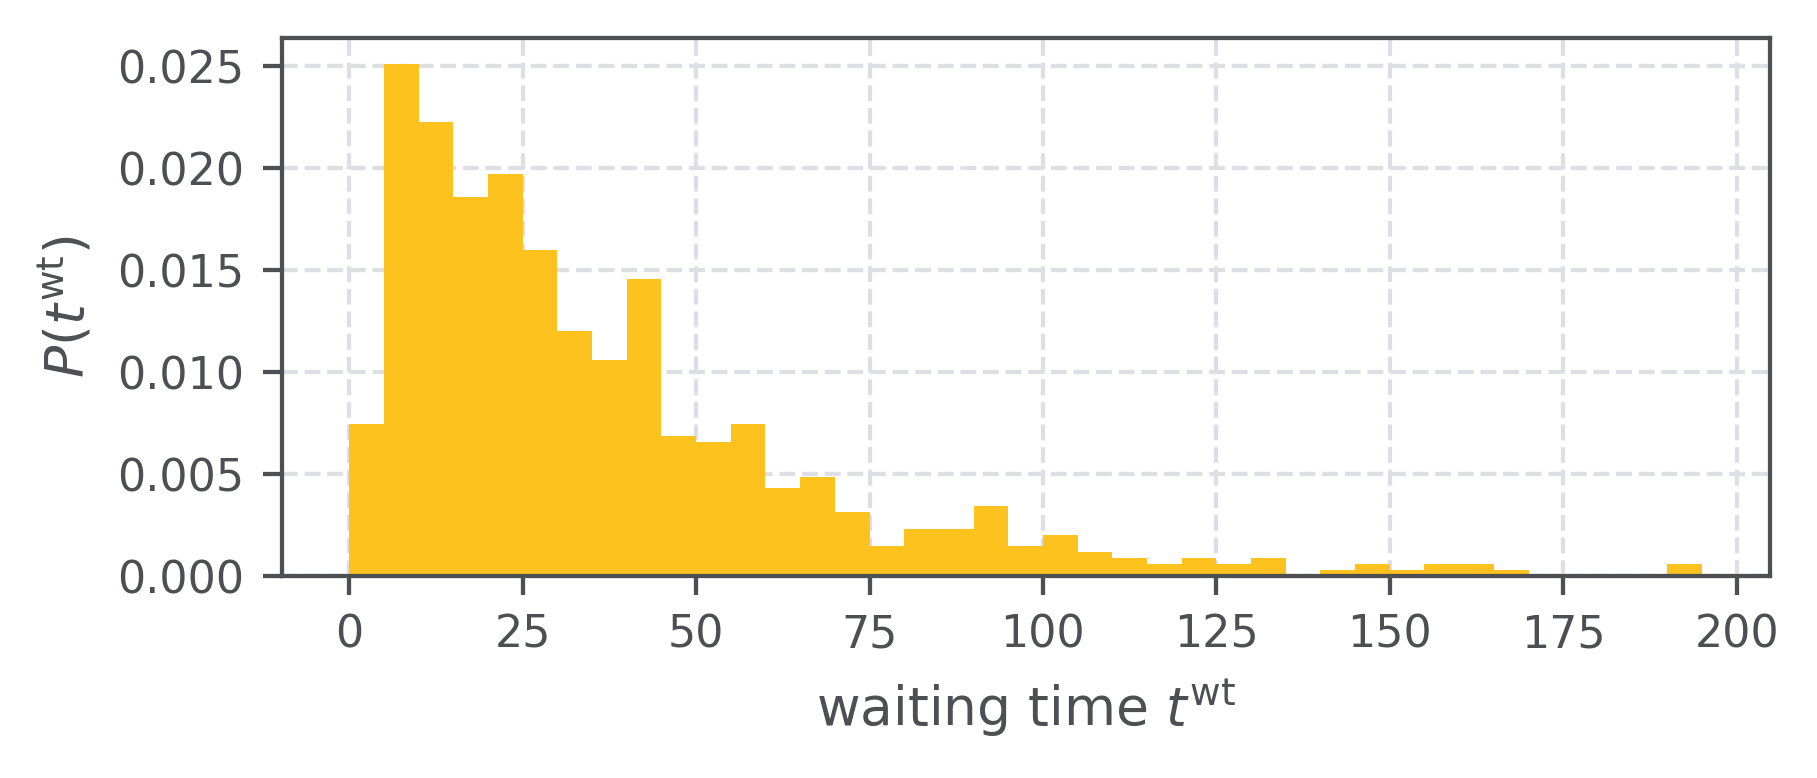

In [3]:
import numpy as np
import prettypyplot as pplt
from matplotlib import pyplot as plt

pplt.use_style(figsize=(5,2), latex=False, colors='paula')

fig, ax = plt.subplots()
# ensure that bins are integers.
bins = np.arange(0, wts.max() + 5, 5)
ax.hist(wts, bins=bins, density=True)
ax.set_xlabel(r'waiting time $t^\mathrm{wt}$')
ax.set_ylabel(r'$P(t^\mathrm{wt})$')
plt.show()

## Estimating Paths from MD

So let us now take a look at the pathways.

In [4]:
paths = mh.md.estimate_paths(traj_4state, start, final)

# Let's format the output
print(f'Identified pathways with time of events given in [frames]:')
for path, pathtimes in paths.items():
    print(f'{path}: {pathtimes}')

Identified pathways with time of events given in [frames]:
(1, 3, 2, 4): [41, 24, 15, 40, 54, 9, 54, 74, 16, 12, 18, 18, 28, 43, 49, 13, 56, 37, 40, 59, 29, 20, 53, 20, 64, 79, 95, 132, 15, 40, 7, 13, 31, 52, 42, 17, 41, 35, 133, 24, 47, 12, 24, 17, 40, 97, 11, 15, 28, 45, 13, 37, 20, 20, 36, 14, 143, 18, 11, 18, 48, 12, 21, 69, 11, 17, 22, 19, 93, 13, 43, 15, 10, 42, 7, 43, 9, 41, 23, 56, 12, 18, 27, 52, 58, 13]
(1, 3, 4): [27, 14, 10, 3, 65, 33, 60, 84, 88, 14, 10, 107, 2, 41, 73, 10, 63, 26, 20, 46, 34, 8, 29, 56, 57, 34, 84, 9, 20, 8, 27, 51, 15, 50, 41, 18, 7, 38, 67, 29, 42, 32, 10, 3, 22, 91, 32, 19, 11, 41, 21, 16, 43, 40, 27, 3, 5, 88, 4, 158, 12, 76, 6, 13, 9, 32, 15, 10, 43, 33, 27, 20, 23, 17, 9, 12, 26, 97, 19, 61, 40, 8, 31, 18, 12, 37, 25, 19, 15, 33, 48, 14, 53, 49, 8, 90, 25, 87, 24, 89, 68, 5, 90, 59, 39, 23, 51, 95, 35, 10, 193, 28, 29, 9, 40, 30, 26, 30, 16, 64, 28, 117, 4, 6, 69, 48, 57, 4, 87, 65, 10, 58, 12, 13, 8, 8, 13, 5, 18, 113, 70, 12, 19, 9, 21, 24, 13, 7,

If we now want to see how frequent these different pathways occur, we can simple reduce the above result via

In [5]:
path_frequencies = sorted(
    ((path, len(pathtimes)) for path, pathtimes in paths.items()),
    key=lambda pathfreq: pathfreq[1],
    reverse=True,
)
n_sampled_paths = np.sum([freq for _, freq in path_frequencies])

# Let's format the output
print(f'Identified pathways with time of events given in [frames]:')
for path, freq in path_frequencies:
    print(f'{path}:\t{freq / n_sampled_paths:.1%}')

Identified pathways with time of events given in [frames]:
(1, 2, 4):	37.1%
(1, 3, 4):	36.7%
(1, 2, 3, 4):	14.0%
(1, 3, 2, 4):	12.3%


Comparing these results to the true values of $37.5\%$ and $12.5\%$ (see Nagel et al. 20), we find a rather good agreement.

## Estimating Timescales from MSM

Now we want to compare how well the Markov model is able to recover the true waiting time distributions and path frequencies.

Identified number of waiting times events: 142401


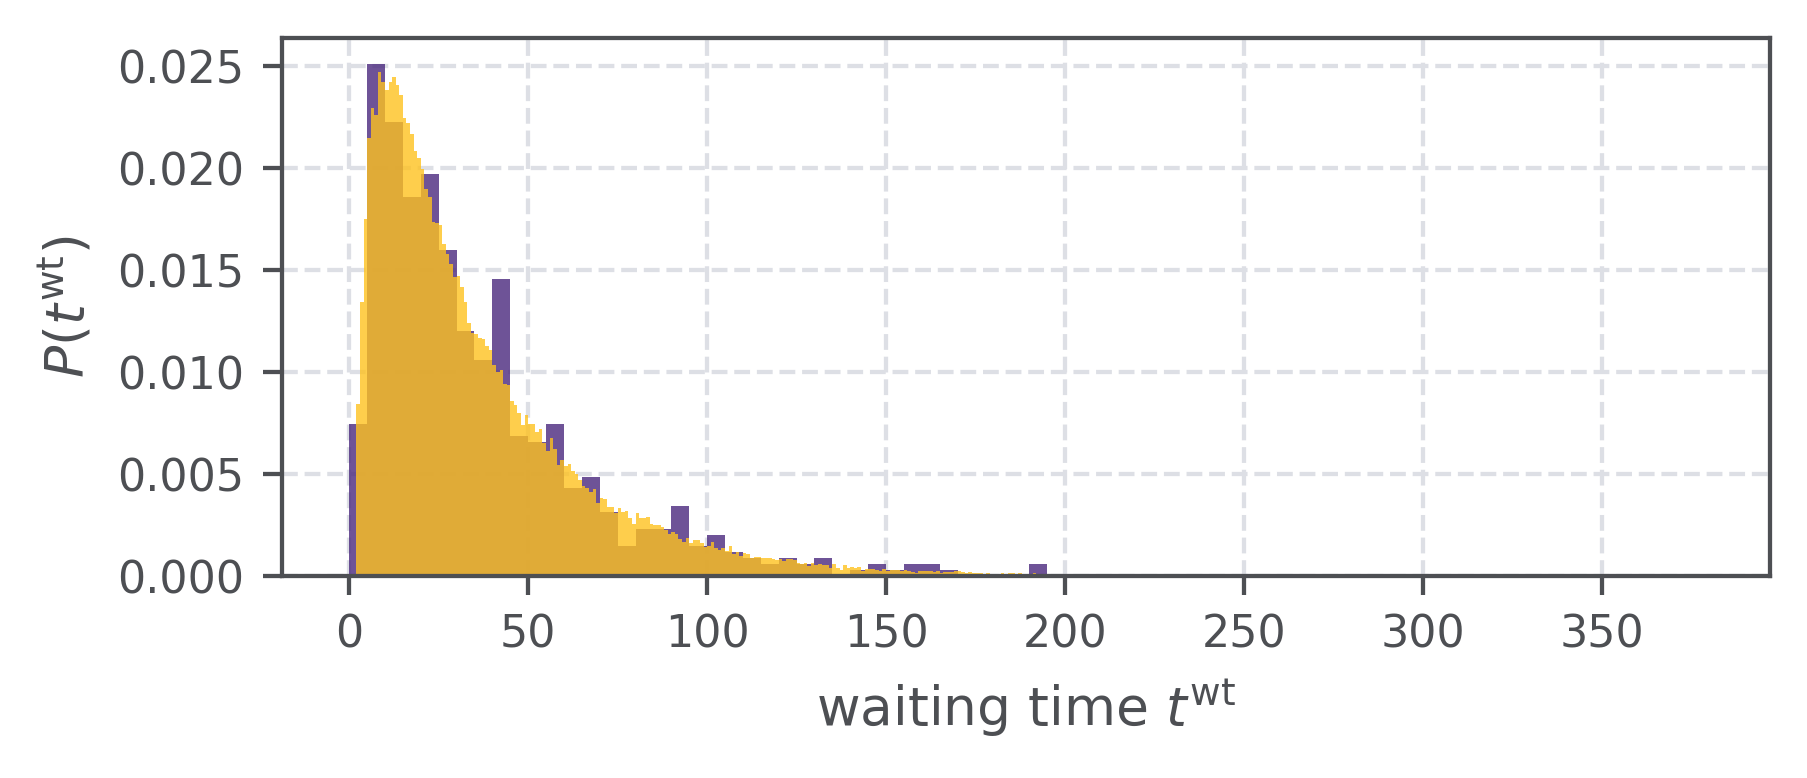

In [6]:
nsteps = int(1e7)
lagtime = 1
wts_msm = mh.msm.estimate_wt(
    trajs=traj_4state,
    lagtime=lagtime,
    start=start,
    final=final,
    steps=nsteps,
    return_list=True,
)

print(f'Identified number of waiting times events: {len(wts_msm)}')

fig, ax = plt.subplots()
# ensure that bins are integers.
bins_msm = np.arange(0, wts_msm.max() + 1)
ax.hist(wts, bins=bins, color='C4', density=True, alpha=0.8)
ax.hist(wts_msm, bins=bins_msm, density=True, alpha=0.8)
ax.set_xlabel(r'waiting time $t^\mathrm{wt}$')
ax.set_ylabel(r'$P(t^\mathrm{wt})$')
plt.show()

So we see, that we get a smooth interpolation of the waiting time distribution.

## Estimating Paths from MSM

Estimating pathways is straight forward and can be achieved by,

In [7]:
paths = mh.msm.estimate_paths(
    trajs=traj_4state,
    lagtime=lagtime,
    start=start,
    final=final,
    steps=nsteps,
)

path_frequencies = sorted(
    ((path, len(pathtimes)) for path, pathtimes in paths.items()),
    key=lambda pathfreq: pathfreq[1],
    reverse=True,
)
n_sampled_paths = np.sum([freq for _, freq in path_frequencies])

# Let's format the output
print(f'Identified pathways with time of events given in [frames]:')
for path, freq in path_frequencies:
    print(f'{path}:\t{freq / n_sampled_paths:.1%}')

Identified pathways with time of events given in [frames]:
(1, 2, 4):	38.3%
(1, 3, 4):	37.0%
(1, 2, 3, 4):	12.8%
(1, 3, 2, 4):	11.9%


## Comparing Waiting Times of MD vs MSM

Finally, we want to directly compare the effect of alternating the lag time $\tau$ on the waiting time distribution. Similar to the implied timescale plot, we can also compare the waiting time distribution for a given lag time to the resulting MD waiting time distribution. To circumvent the problem of poor statistics, we rely in this analysis only on statistical quantaties instead of the probability distributions: Namely, the three quartiles $Q_{1,2,3}$, and the interquartile range $\mathrm{IQR}=Q_3 - Q_1$.

This can be easily achieved with the predefinied functions:

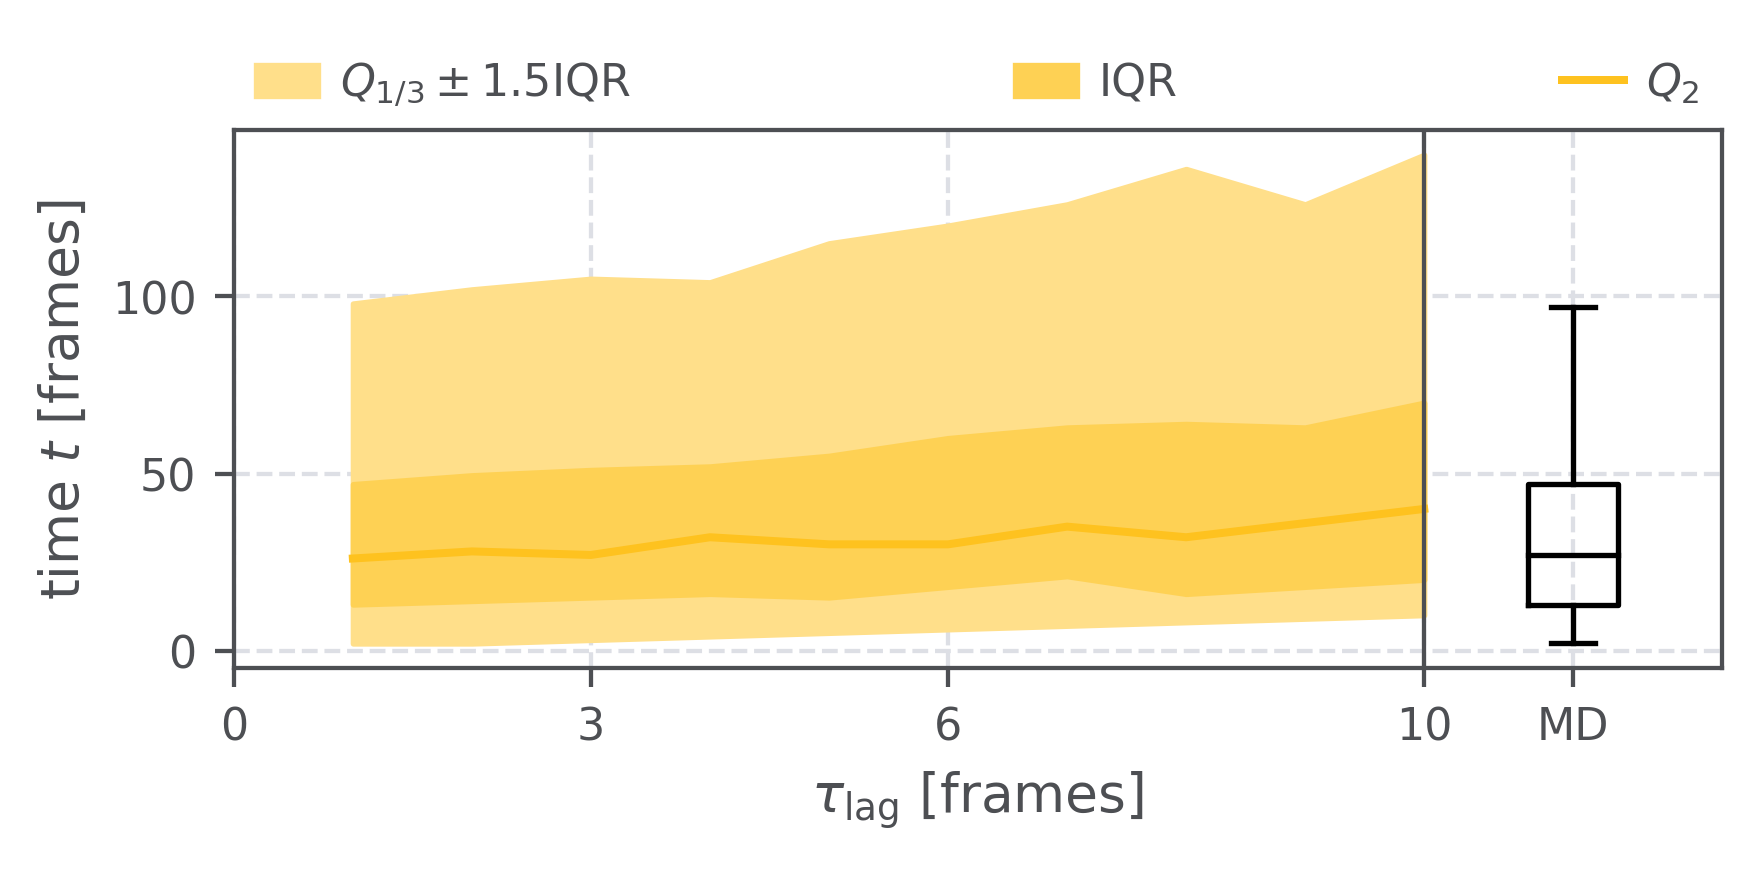

In [8]:
wtd = mh.msm.estimate_wtd(
    trajs=traj_4state,
    max_lagtime=10,
    start=start,
    final=final,
    steps=nsteps,
)
fig, ax = plt.subplots()
ax = mh.plot.plot_wtd(wtd=wtd)
plt.show()

Here we see, that choosing a long lag time 

## Concluding Remarks

In conclusion, we have learned how to estimate waiting times and transition pathways directly from the state trajectory and via Markov state modeling. By analyzing the timescales and pathways of a system, we can gain valuable insights into its dynamics and compare them with experimental observations. We hope that this tutorial has provided a useful introduction to the estimation of waiting times and pathways in protein dynamics and will inspire further investigations into the dynamics of complex biological systems. We will continue to see how the Hummer-Szabo projection can be used to improve the general MSM prediction of lumped microstate dynamics.